In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = False)

Mounted at /content/drive/


In [2]:
!rm -rf /content/dataset/ /content/test/ /content/train/

In [3]:
!unzip /content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-20/dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset/test/corpse/corpse_images_51.png  
 extracting: dataset/test/corpse/corpse_images_57.png  
 extracting: dataset/test/corpse/corpse_images_64.png  
 extracting: dataset/test/corpse/corpse_images_69.png  
 extracting: dataset/test/corpse/corpse_images_7.png  
  inflating: dataset/test/corpse/corpse_images_76.png  
  inflating: dataset/test/corpse/corpse_images_84.png  
 extracting: dataset/test/corpse/corpse_images_90.png  
   creating: dataset/test/crane/
 extracting: dataset/test/crane/crane_images_104.png  
 extracting: dataset/test/crane/crane_images_107.png  
 extracting: dataset/test/crane/crane_images_108.png  
 extracting: dataset/test/crane/crane_images_112.png  
 extracting: dataset/test/crane/crane_images_116.png  
 extracting: dataset/test/crane/crane_images_119.png  
 extracting: dataset/test/crane/crane_images_120.png  
 extracting: dataset/test/crane/crane_images_121.png  
 extracting: dataset/test/cra

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import os
import itertools
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

np.random.seed(42)

Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (439/439), done.
remote: Total 23737 (delta 234), reused 618 (delta 174), pack-reused 23036
Receiving objects: 100% (23737/23737), 44.19 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (12882/12882), done.


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-20/train_data_MoveNet_Reseized.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-20/test_data_MoveNet_Resized.csv')

In [6]:
train_df.head()

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,bow/bow_images_1.png,31.0,109.0,0.751285,38.0,105.0,0.773953,36.0,105.0,0.627605,...,133.0,0.681616,135.0,82.0,0.618168,137.0,81.0,0.403138,0,bow
1,bow/bow_images_10.png,171.0,93.0,0.799384,169.0,86.0,0.889267,165.0,87.0,0.819585,...,124.0,0.855907,83.0,62.0,0.174297,46.0,78.0,0.658785,0,bow
2,bow/bow_images_100.png,33.0,46.0,0.791195,42.0,42.0,0.641554,40.0,41.0,0.808471,...,175.0,0.635551,173.0,101.0,0.735479,172.0,99.0,0.496938,0,bow
3,bow/bow_images_101.png,42.0,109.0,0.295836,43.0,104.0,0.354434,44.0,103.0,0.271474,...,147.0,0.416382,145.0,88.0,0.418477,143.0,88.0,0.280069,0,bow
4,bow/bow_images_102.png,147.0,103.0,0.751310,145.0,97.0,0.863349,141.0,98.0,0.576931,...,121.0,0.840785,65.0,76.0,0.294251,57.0,75.0,0.709282,0,bow


In [7]:
train_path = '/content/dataset/train/'
class_names = os.listdir(train_path)
count = 0
for class_name in class_names:
    class_path = os.path.join(train_path, class_name)
    all_files = os.listdir(class_path)
    for file in all_files:
        file_path = os.path.join(class_path,file)
        name_to_check_df = class_name + "/" + file
        if train_df['file_name'].isin([name_to_check_df]).any():
            count+=1
        else:
            os.remove(file_path)
            print(f"Removed: {file_path}")


Removed: /content/dataset/train/cat/cat_images_29.png
Removed: /content/dataset/train/cat/cat_images_178.png
Removed: /content/dataset/train/cat/cat_images_19.png
Removed: /content/dataset/train/cat/cat_images_59.png
Removed: /content/dataset/train/cat/cat_images_101.png
Removed: /content/dataset/train/corpse/corpse_images_183.png
Removed: /content/dataset/train/corpse/corpse_images_170.png
Removed: /content/dataset/train/corpse/corpse_images_226.png
Removed: /content/dataset/train/corpse/corpse_images_171.png
Removed: /content/dataset/train/corpse/corpse_images_1.png
Removed: /content/dataset/train/corpse/corpse_images_128.png
Removed: /content/dataset/train/corpse/corpse_images_68.png
Removed: /content/dataset/train/corpse/corpse_images_156.png
Removed: /content/dataset/train/corpse/corpse_images_221.png
Removed: /content/dataset/train/corpse/corpse_images_237.png
Removed: /content/dataset/train/corpse/corpse_images_230.png
Removed: /content/dataset/train/corpse/corpse_images_197.png

In [8]:
if len(train_df) == count:
    print("Irrelevant Files were removed")
else:
    print("Irrelevant Files were not removed")

Irrelevant Files were removed


In [9]:
test_path = '/content/dataset/test/'
class_names = os.listdir(test_path)
count = 0
for class_name in class_names:
    class_path = os.path.join(test_path, class_name)
    all_files = os.listdir(class_path)
    for file in all_files:
        file_path = os.path.join(class_path,file)
        name_to_check_df = class_name + "/" + file
        if test_df['file_name'].isin([name_to_check_df]).any():
            count+=1
        else:
            os.remove(file_path)
            print(f"Removed: {file_path}")


Removed: /content/dataset/test/cat/cat_images_210.png
Removed: /content/dataset/test/corpse/corpse_images_153.png
Removed: /content/dataset/test/corpse/corpse_images_16.png
Removed: /content/dataset/test/corpse/corpse_images_32.png
Removed: /content/dataset/test/corpse/corpse_images_116.png
Removed: /content/dataset/test/corpse/corpse_images_113.png
Removed: /content/dataset/test/corpse/corpse_images_14.png
Removed: /content/dataset/test/corpse/corpse_images_227.png
Removed: /content/dataset/test/corpse/corpse_images_173.png
Removed: /content/dataset/test/corpse/corpse_images_24.png
Removed: /content/dataset/test/corpse/corpse_images_225.png
Removed: /content/dataset/test/corpse/corpse_images_4.png
Removed: /content/dataset/test/corpse/corpse_images_218.png
Removed: /content/dataset/test/corpse/corpse_images_245.png
Removed: /content/dataset/test/corpse/corpse_images_36.png
Removed: /content/dataset/test/corpse/corpse_images_76.png
Removed: /content/dataset/test/upward_salute/upwardsal

In [10]:
if len(test_df) == count:
    print("Irrelevant Files were removed")
else:
    print("Irrelevant Files were not removed")

Irrelevant Files were removed


In [11]:
def preprocess_df(df):
    df = df.dropna()
    df = df.reset_index(drop=True)
    print('-----------------------------------------------------------')
    print(f"The Length of dataframe is = {len(df)}")
    print('-----------------------------------------------------------')
    unique_classes = df['class_name'].unique()
    print('-----------------------------------------------------------')
    print('The List of Unqiue classes:')
    print(unique_classes)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    print('The number of classes = ',len(unique_classes))
    print('-----------------------------------------------------------')
    any_null_values = df.isnull().values.any()
    print('-----------------------------------------------------------')
    print("\nAre there any null values in the DataFrame?")
    print(any_null_values)
    print('-----------------------------------------------------------')
    return df, len(unique_classes)

def load_landmarks(df):
    df.drop(columns=['file_name'], inplace=True)
    classes = df.pop('class_name').unique()
    x_images = df.pop('image')
    y = df.pop('class_no')
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    return X, y, classes, x_images, df

def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # Resize image to match ResNet50 input shape
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img

In [13]:
len(train_df)

3708

In [12]:
classes = train_df['class_name'].unique()
classes

array(['bow', 'bridge', 'cat', 'chair', 'corpse', 'crane', 'diamond',
       'downdog', 'garland', 'goddess', 'lotus', 'plank',
       'seated_forward_fold', 'side_plank', 'standing_forward_bend',
       'tree', 'upward_salute', 'warrior1', 'warrior3', 'wheel'],
      dtype=object)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
import pandas as pd
import numpy as np
import os
import utils
from data import BodyPart
from ml import Movenet

In [15]:
# Path to the directory containing the images
image_path_train = '/content/dataset/train/'
image_path_test = '/content/dataset/test/'
# Load and preprocess images and add them as a column named 'image' to the DataFrame
train_df['image'] = train_df['file_name'].apply(lambda x: load_and_preprocess_image(os.path.join(image_path_train, x)))
test_df['image'] = test_df['file_name'].apply(lambda x: load_and_preprocess_image(os.path.join(image_path_test, x)))
# Display the DataFrame with the added 'image' column


In [16]:
X_train_landmarks, y_train_landmarks, classes, x_train_images, _ = load_landmarks(train_df)
X_test_landmarks, y_test_landmarks, _, x_test_images, _ = load_landmarks(test_df)

In [18]:
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
class BilinearPooling(layers.Layer):
    def __init__(self, **kwargs):
        super(BilinearPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(BilinearPooling, self).build(input_shape)

    def call(self, inputs):
        x1, x2 = inputs
        batch_size = K.shape(x1)[0]
        num_channels = K.shape(x1)[-1]

        x1_flat = K.reshape(x1, (batch_size, -1, num_channels))
        x2_flat = K.reshape(x2, (batch_size, -1, num_channels))

        bilinear_pooling = K.batch_dot(x1_flat, x2_flat, axes=[1, 1]) / K.prod(K.cast(K.shape(x1_flat)[1:-1], 'float32'))

        return K.sqrt(K.abs(bilinear_pooling) + 1e-8)

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][-1])

In [19]:
# Define landmark input
landmark_inputs = keras.Input(shape=(51), name='landmark_input')
landmark_inputs = landmarks_to_embedding(landmark_inputs)
landmark_layer = keras.layers.Dense(256, activation=tf.nn.relu6)(landmark_inputs)
landmark_layer = keras.layers.Dropout(0.3)(landmark_layer)
landmark_layer = keras.layers.Dense(64, activation=tf.nn.relu6)(landmark_layer)
landmark_layer = keras.layers.Dropout(0.3)(landmark_layer)

# Define ResNet50 model for image inputs
resnet_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = False

# Define image input
image_inputs = keras.Input(shape=(224, 224, 3), name='image_input')
resnet_output = resnet_model(image_inputs)
resnet_output = keras.layers.Flatten()(resnet_output)
resnet_output = keras.layers.Dense(256, activation = 'relu')(resnet_output)
resnet_output = keras.layers.BatchNormalization()(resnet_output)
resnet_output = keras.layers.Dropout(0.5)(resnet_output)
resnet_output = keras.layers.Dense(64, activation = 'relu')(resnet_output)
resnet_output = keras.layers.BatchNormalization()(resnet_output)
resnet_output = keras.layers.Dropout(0.5)(resnet_output)

# Calculate scaled dot-product attention
attention_scores = keras.layers.Dot(axes=-1)([landmark_layer, resnet_output])
attention_scores = keras.layers.Softmax()(attention_scores)  # Normalize attention weights

# Apply attention weights
weighted_landmark = keras.layers.Multiply()([landmark_layer, attention_scores])
weighted_image = keras.layers.Multiply()([resnet_output, attention_scores])

# Combine weighted representations - consider alternatives to just averaging
combined_features = keras.layers.Average()([weighted_landmark, weighted_image])
combined_features = keras.layers.BatchNormalization()(combined_features)
# Output layer for multi-class classification
outputs = keras.layers.Dense(len(classes), activation='softmax')(combined_features)

# Define the updated hybrid model
hybrid_model = keras.Model(inputs=[landmark_inputs, image_inputs], outputs=outputs)
hybrid_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['image_input[0][0]']         
                                                          2                                       
                                                                                                  
 flatten (Flatten)           (None, 100352)               0         ['resnet50[0][0]']            
                                                                                                  
 dense_2 (Dense)             

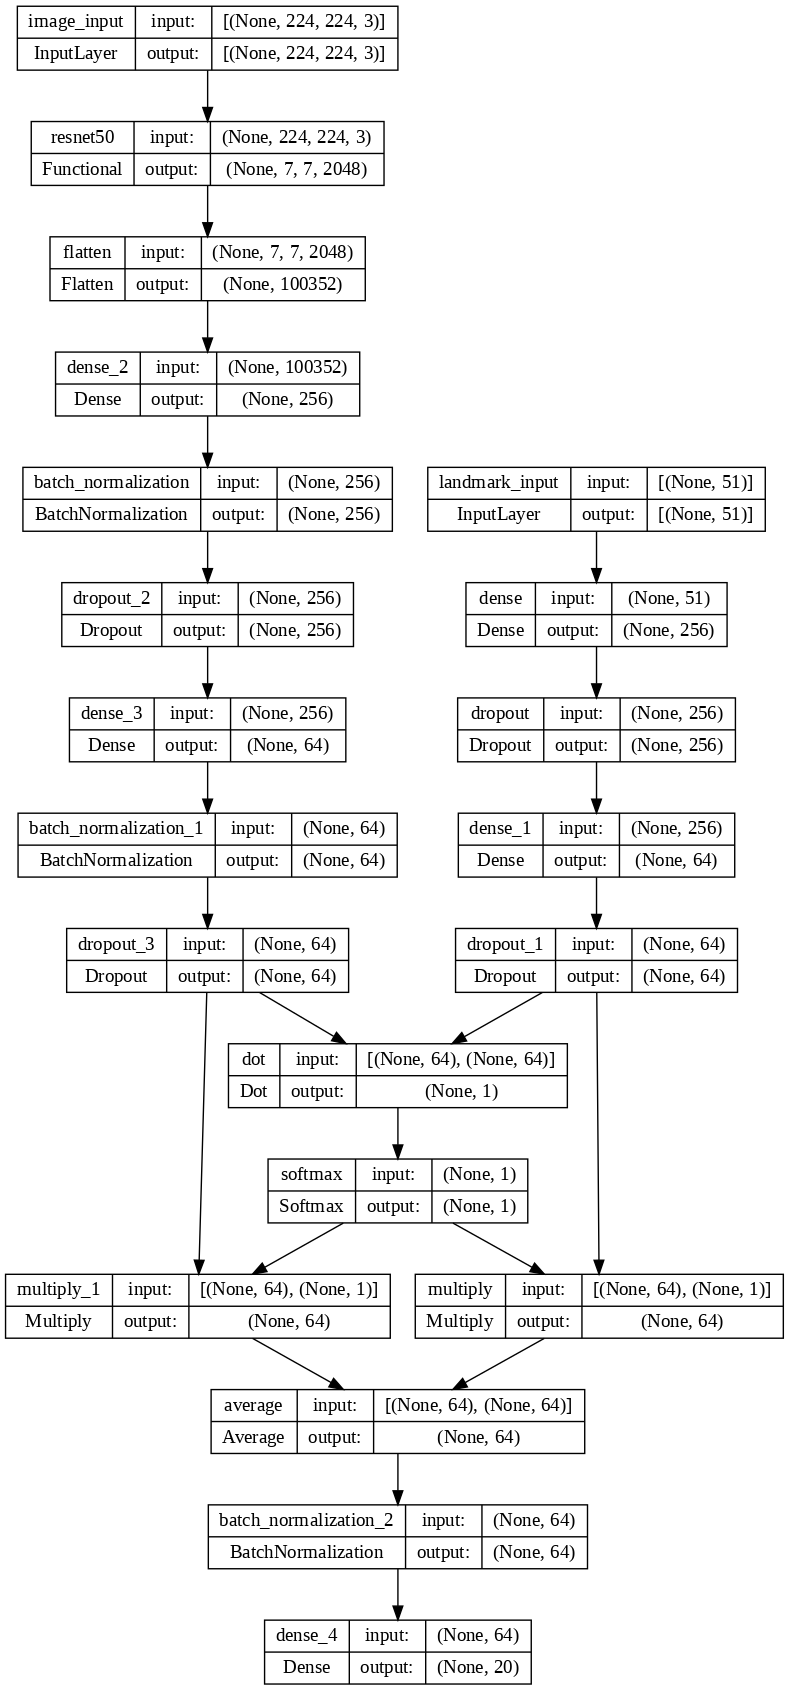

In [20]:
import keras

# Visualize the model
keras.utils.plot_model(hybrid_model, expand_nested=False, dpi=100, show_shapes=True)

In [21]:
print(X_train_landmarks.shape)
print(x_train_images[1].shape)

(3708, 51)
(224, 224, 3)


In [22]:
X_train_landmarks_np = X_train_landmarks.values.astype('float64')
x_train_images_np = np.stack(x_train_images.values)
y_train_landmarks_np = y_train_landmarks

X_test_landmarks_np = X_test_landmarks.values.astype('float64')
y_test_landmarks_np = y_test_landmarks
x_test_images_np = np.stack(x_test_images.values)


In [23]:
print(type(X_train_landmarks_np))
print(type(x_train_images_np))
print(type(y_train_landmarks_np))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [24]:
hybrid_model.compile(
    optimizer= 'adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights_hybrid.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
history = hybrid_model.fit([X_train_landmarks_np, x_train_images_np],y_train_landmarks_np,
                    epochs=100,
                    batch_size=32,
                    validation_data = ([X_test_landmarks_np, x_test_images_np], y_test_landmarks_np),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/100
116/116 [==============================] - ETA: 0s - loss: 1.9248 - accuracy: 0.4396
Epoch 1: val_accuracy improved from -inf to 0.85441, saving model to weights_hybrid.keras
116/116 [==============================] - 19s 78ms/step - loss: 1.9248 - accuracy: 0.4396 - val_loss: 0.6898 - val_accuracy: 0.8544
Epoch 2/100
115/116 [============================>.] - ETA: 0s - loss: 0.8136 - accuracy: 0.8163
Epoch 2: val_accuracy improved from 0.85441 to 0.92561, saving model to weights_hybrid.keras
116/116 [==============================] - 7s 57ms/step - loss: 0.8121 - accuracy: 0.8166 - val_loss: 0.4074 - val_accuracy: 0.9256
Epoch 3/100
115/116 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.9231
Epoch 3: val_accuracy improved from 0.92561 to 0.94793, saving model to weights_hybrid.keras
116/116 [==============================] - 6s 54ms/step - loss: 0.4349 - accuracy: 0.9229 - val_loss: 0.2525 - val_accuracy: 0.9479
Epoch 4/100
115/116 [===============

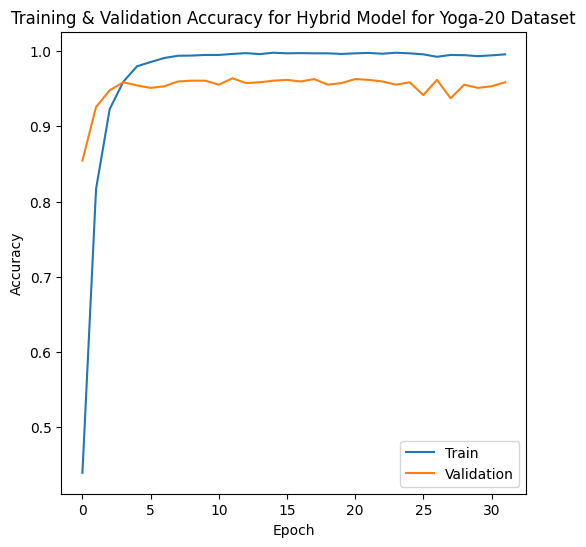

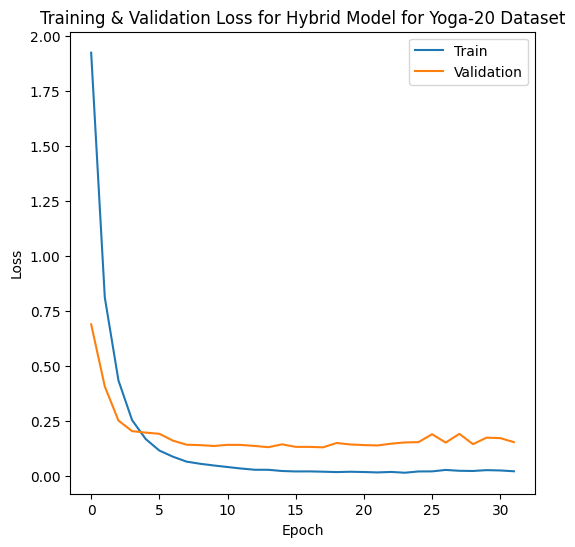

In [25]:
from matplotlib import pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training & Validation Accuracy for Hybrid Model for Yoga-20 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('Accuracy_Graph_Hybrid.png')
plt.show()
# Plot training & validation loss values
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training & Validation Loss for Hybrid Model for Yoga-20 Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('Loss_Graph_Hybrid.png')

plt.show()


In [26]:
hybrid_model = tf.keras.models.load_model('weights_hybrid.keras')
hybrid_model.evaluate([X_test_landmarks_np, x_test_images_np], y_test_landmarks_np)

30/30 [==============================] - 3s 24ms/step - loss: 0.1414 - accuracy: 0.9639


[0.14142541587352753, 0.9638682007789612]

30/30 [==============================] - 2s 23ms/step


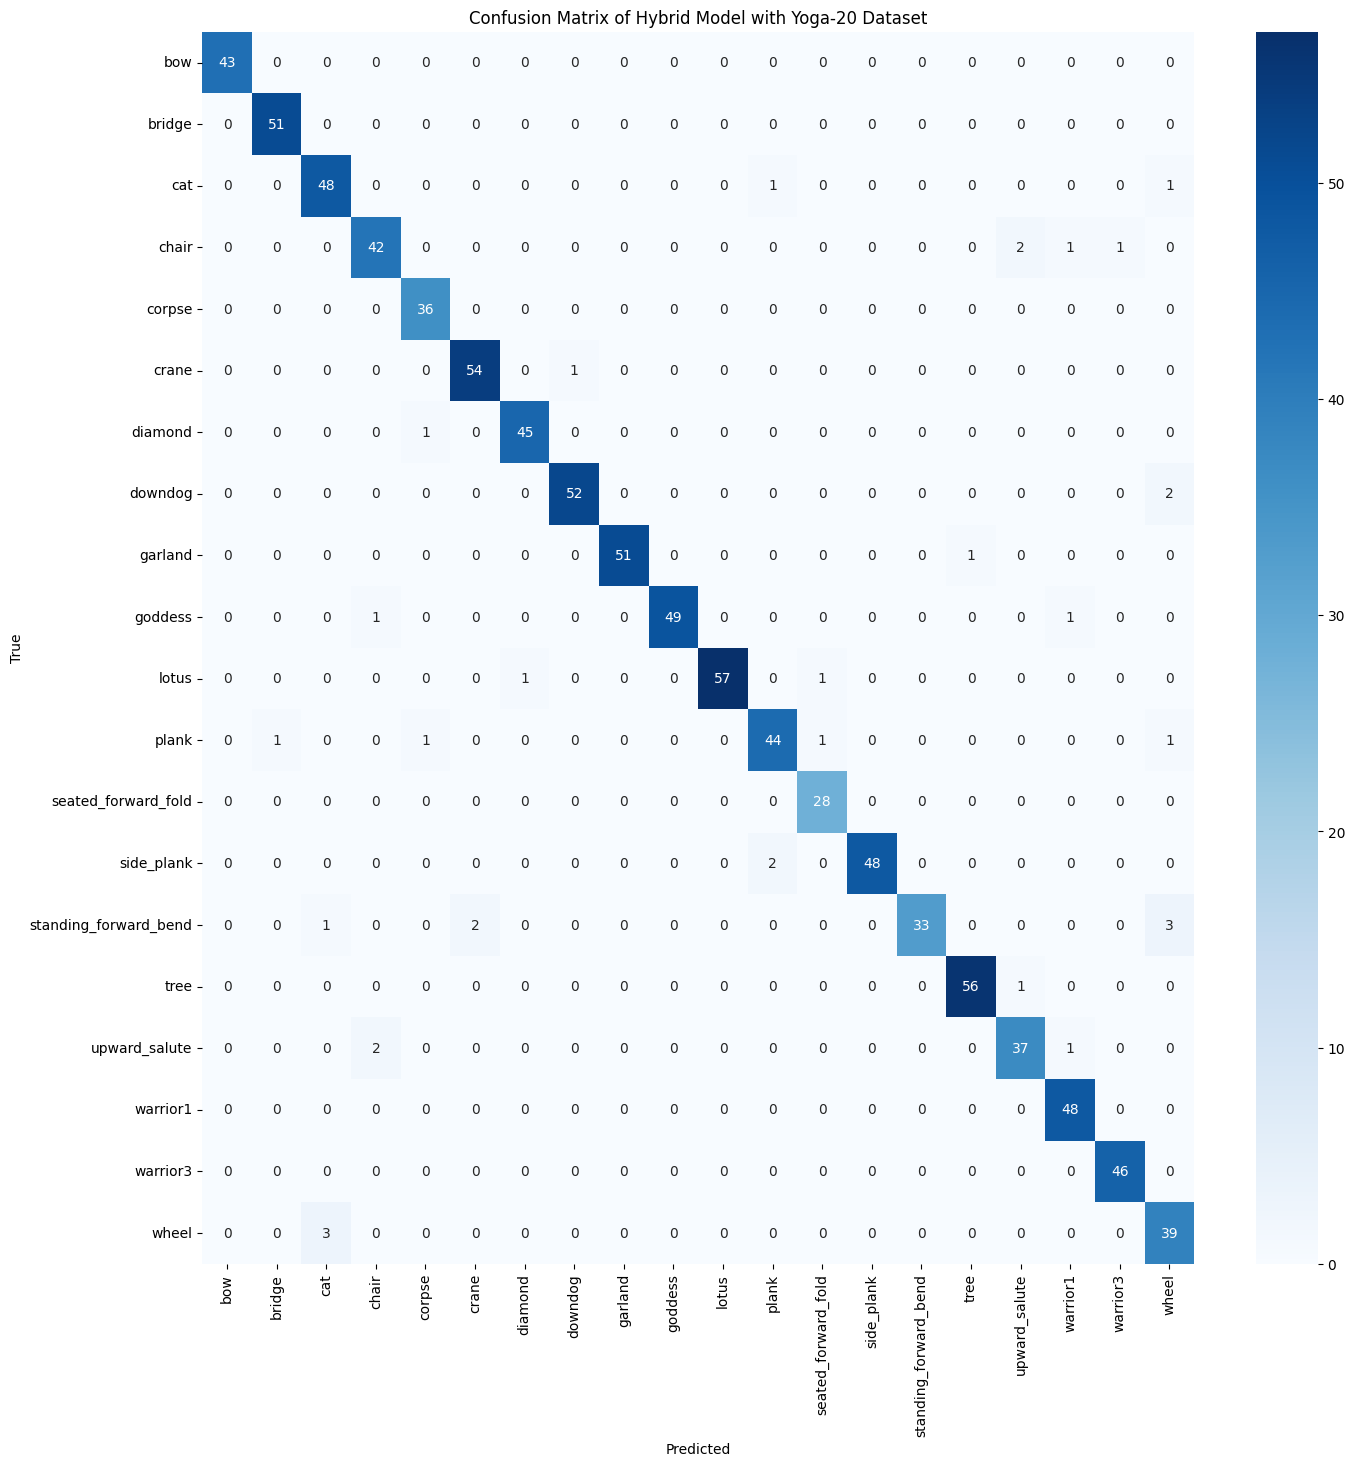

                       precision    recall  f1-score   support

                  bow       1.00      1.00      1.00        43
               bridge       0.98      1.00      0.99        51
                  cat       0.92      0.96      0.94        50
                chair       0.93      0.91      0.92        46
               corpse       0.95      1.00      0.97        36
                crane       0.96      0.98      0.97        55
              diamond       0.98      0.98      0.98        46
              downdog       0.98      0.96      0.97        54
              garland       1.00      0.98      0.99        52
              goddess       1.00      0.96      0.98        51
                lotus       1.00      0.97      0.98        59
                plank       0.94      0.92      0.93        48
  seated_forward_fold       0.93      1.00      0.97        28
           side_plank       1.00      0.96      0.98        50
standing_forward_bend       1.00      0.85      0.92  

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_pred = hybrid_model.predict([X_test_landmarks_np, x_test_images_np])
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_landmarks_np, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix of Hybrid Model with Yoga-20 Dataset')
plt.savefig('Confusion_Matrix_Hybrid.png')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=classes)
print(class_report)

In [28]:
import zipfile
import os
import pickle

with open('history_for_Hybrid.pkl', 'wb') as f:
    pickle.dump(history, f)

def create_zip(files_to_zip, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in files_to_zip:
            # Add the file to the zip archive
            zipf.write(file, os.path.basename(file))

# Example: List of files to be included in the zip
files_to_zip = ['Accuracy_Graph_Hybrid.png', 'Loss_Graph_Hybrid.png', 'history_for_Hybrid.pkl', 'weights_hybrid.keras', 'Confusion_Matrix_Hybrid.png']

# Specify the name of the zip file
zip_filename = 'results_Hybrid_With_Attention_Mechanism_and_Late_Fusion.zip'

# Create the zip file
create_zip(files_to_zip, zip_filename)


In [29]:
!cp {zip_filename} /content/drive/MyDrive/Datasets/YogaPoseEstimation/Images/Yoga-20/